# Exercise 1.4

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need.

**NB! The exercise is formulated in a Jupyter notebook for ease of communication, but you should feel *very* free to carry out the entire exercise without the notebook. If you do carry it out in a notebook, please finish by migrating your code over to a script that you can run from the terminal**

In [25]:
import os
if os.getcwd().split("/")[-1] != "ex1":
    os.chdir("exercises/ex1")
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We always check that we are running on a GPU

In [26]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [27]:
batch_size = 64
trainset = datasets.CIFAR10('./cifar10_data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10('./cifar10_data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:09<00:00, 17874009.39it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


* Make a CNN to train on the CIFAR10 dataset

In [28]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.BatchNorm2d(3),
                nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.BatchNorm2d(8),
                # nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, stride=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                # nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1),
        )
        
        self.fully_connected = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(16*16*16, 500),
                nn.ReLU(),
                nn.BatchNorm1d(500),
                nn.Dropout(p=0.5),
                nn.Linear(500, 10),
                nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [65]:
# model = Network()
# model.to(device)
# #Initialize the optimizer
# # optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10, loss = "CrossEntropyLoss"):
    if loss == "CrossEntropyLoss":
        def loss_fun(output, target):
            return F.cross_entropy(output, target)
    else:
        def loss_fun(output, target):
            return F.nll_loss(torch.log(output), target)
        
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            
            if loss.isnan():
                raise ValueError("Loss is NaN")
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [7]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict_sgd = train(model, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.708	 test: 1.770	 Accuracy train: 43.0%	 test: 43.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.375	 test: 1.235	 Accuracy train: 52.5%	 test: 57.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.236	 test: 1.195	 Accuracy train: 57.1%	 test: 58.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.126	 test: 1.331	 Accuracy train: 60.5%	 test: 56.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.054	 test: 1.035	 Accuracy train: 63.1%	 test: 63.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.992	 test: 1.004	 Accuracy train: 65.3%	 test: 64.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.940	 test: 0.904	 Accuracy train: 66.9%	 test: 67.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.904	 test: 0.936	 Accuracy train: 68.3%	 test: 66.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.878	 test: 0.878	 Accuracy train: 69.2%	 test: 69.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.845	 test: 0.823	 Accuracy train: 70.2%	 test: 71.1%


In [8]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
out_dict_adam = train(model, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.436	 test: 1.143	 Accuracy train: 49.1%	 test: 59.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.182	 test: 1.026	 Accuracy train: 58.0%	 test: 63.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.079	 test: 0.990	 Accuracy train: 62.1%	 test: 64.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.005	 test: 0.939	 Accuracy train: 64.4%	 test: 66.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.948	 test: 0.909	 Accuracy train: 66.6%	 test: 67.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.906	 test: 0.893	 Accuracy train: 68.2%	 test: 68.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.864	 test: 0.847	 Accuracy train: 69.4%	 test: 70.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.825	 test: 0.838	 Accuracy train: 70.7%	 test: 70.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.791	 test: 0.833	 Accuracy train: 72.0%	 test: 70.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.774	 test: 0.814	 Accuracy train: 72.7%	 test: 71.5%


NameError: name 'out_dict_sgd' is not defined

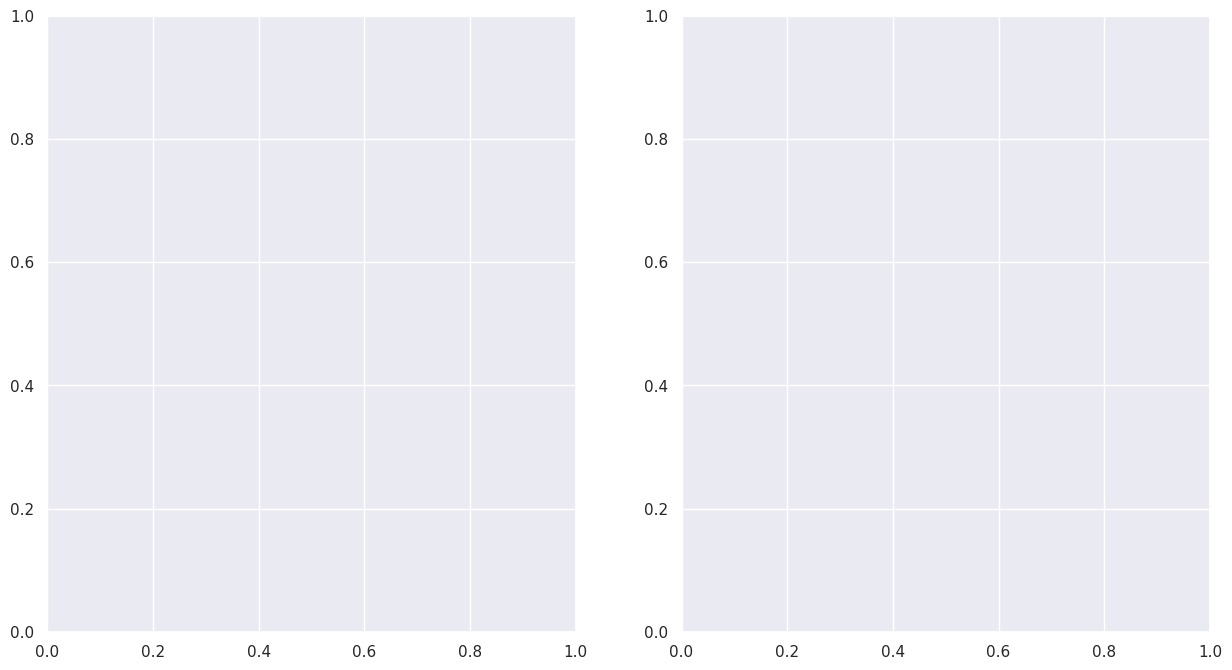

In [30]:
fig, axes = plt.subplots(1,2, figsize=(15,8))


def plot_out_dict(out_dict, axes, name):
    ax = axes[0]
    ax.plot(out_dict['train_acc'], label=f'Train accuracy ({name})')
    ax.plot(out_dict['test_acc'], label=f'Test accuracy ({name})')
    ax.legend()
    ax.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy per epoch')

    ax = axes[1]
    ax.plot(out_dict['train_loss'], label=f'Train loss ({name})')
    ax.plot(out_dict['test_loss'], label=f'Test loss ({name})')
    ax.legend()
    ax.set(xlabel='Epoch', ylabel='Loss', title='Loss per epoch')

plot_out_dict(out_dict_sgd, axes, 'SGD')
plot_out_dict(out_dict_adam, axes, 'Adam')
plt.show()

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

> - Too little dropout gives overfitting, hwoever, the test/train loss/accuracy seems the other way around (test better than train) when using more dropout

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?

> - Much faster

* Which optimizer works best for you?

> - Adam

* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [31]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_features, out_channels=n_features, kernel_size=3, padding=1, stride=1),
        )
        
    def forward(self, x):
        out = self.convolutional(x)
        out += x
        # self.activation(out)
        out = F.relu(out)
        return out

The following code is a sanity of your residual block network

In [32]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

Passed sanity check


We define a network that uses your `ResNetBlock`

In [33]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                # nn.Softmax(dim=1)
                                nn.LogSoftmax(dim=1)
                )
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [34]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.878	 test: 1.639	 Accuracy train: 32.4%	 test: 40.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.468	 test: 1.432	 Accuracy train: 47.6%	 test: 47.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.268	 test: 1.407	 Accuracy train: 54.7%	 test: 49.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.092	 test: 1.546	 Accuracy train: 61.1%	 test: 48.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.877	 test: 2.597	 Accuracy train: 68.7%	 test: 39.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.622	 test: 1.891	 Accuracy train: 78.1%	 test: 48.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.362	 test: 1.967	 Accuracy train: 87.5%	 test: 48.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.215	 test: 2.411	 Accuracy train: 92.6%	 test: 52.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.141	 test: 2.737	 Accuracy train: 95.2%	 test: 51.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.090	 test: 2.859	 Accuracy train: 97.1%	 test: 49.3%




Do you get nan loss at some point during training? 
This can be caused by the numerical instability of using softmax and log as two functions. 
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.

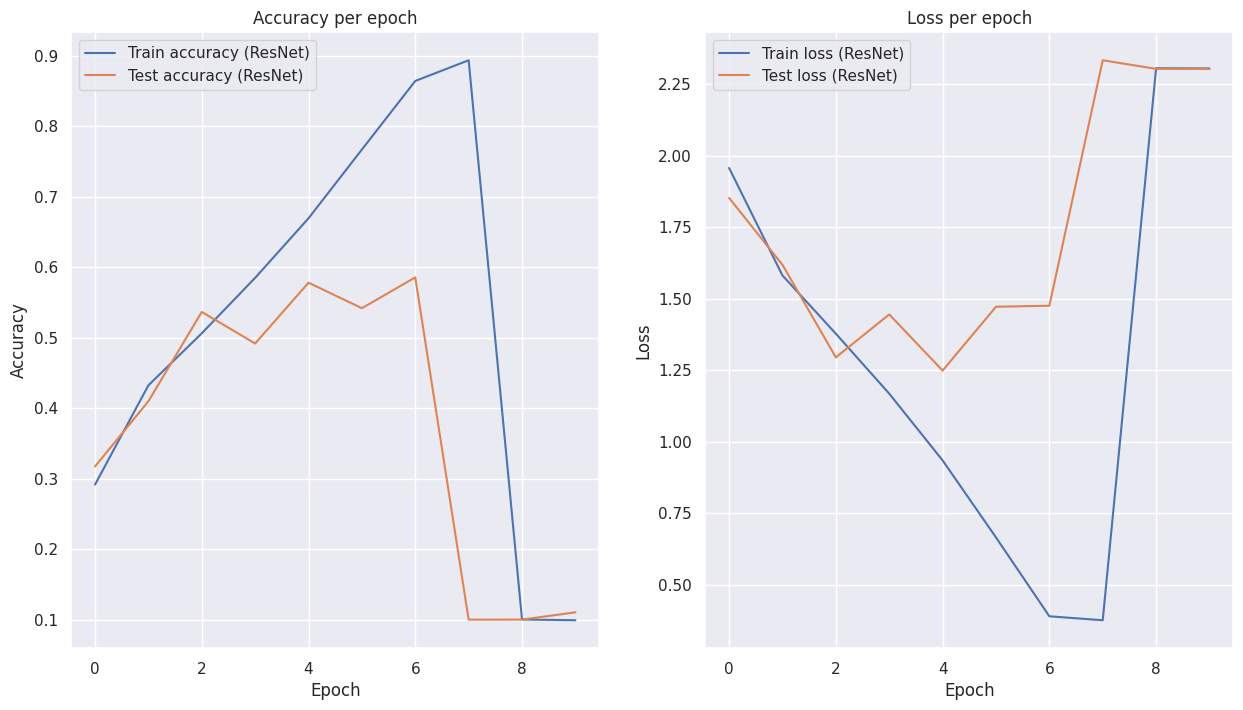

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
plot_out_dict(out_dict, axes, 'ResNet')